In [1]:
from keras.layers import Dense, SimpleRNN
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import keras.backend as K

Using TensorFlow backend.


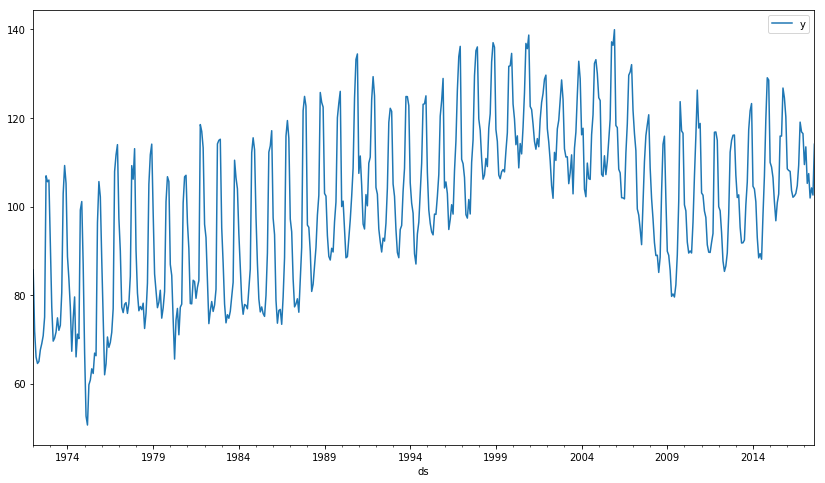

In [2]:
%run setup_workspace.ipynb

In [3]:
data = candy_production
data.head()

ds        y
0 1972-01-01  85.6945
1 1972-02-01  71.8200
2 1972-03-01  66.0229
3 1972-04-01  64.5645
4 1972-05-01  65.0100

# Creating a Recurrent Neural Network

## 1. Train-test-validation-split

In [4]:
split_date = pd.Timestamp(date(2014,10,1))
split_date2 = pd.Timestamp(date(2015,10,1))
min_date = None
max_date = None

train = data[data.ds < split_date]
if min_date is not None:
    train = train[train['ds'] > min_date]

valid = data[(data.ds > split_date) & (data.ds < split_date2)]

test = data[data.ds > split_date2]
if max_date is not None:
    test = test[test['ds'] < max_date]

In [5]:
input_len = 3
rtrain = train.y.values.reshape(len(train.y.values),1)
rtest = test.y.values.reshape(len(test.y.values),1)
rvalid = valid.y.values.reshape(len(valid.y.values),1)
train_generator = TimeseriesGenerator(rtrain, rtrain, length=input_len, batch_size=1)
test_generator = TimeseriesGenerator(rtest, rtest, length=input_len, batch_size=1)            
valid_generator = TimeseriesGenerator(rvalid, rvalid, length=input_len, batch_size=1)

In [6]:
train[0:6]

ds        y
0 1972-01-01  85.6945
1 1972-02-01  71.8200
2 1972-03-01  66.0229
3 1972-04-01  64.5645
4 1972-05-01  65.0100
5 1972-06-01  67.6467

In [7]:
train_generator[0]

(array([[[85.6945],
         [71.82  ],
         [66.0229]]]), array([[64.5645]]))

## 2. Model training

In [8]:
model = Sequential()
model.add(SimpleRNN(30, activation='elu', input_shape=(input_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 30)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=50, verbose=0, 
                               callbacks=[earlyStopping], 
                               validation_data=valid_generator)

Instructions for updating:
Use tf.cast instead.
CPU times: user 3.47 s, sys: 564 ms, total: 4.04 s
Wall time: 5.6 s


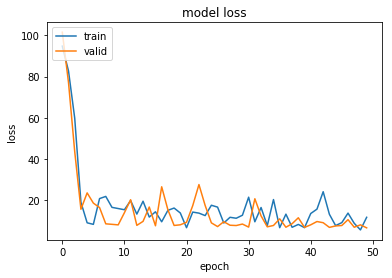

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 3. Forecast 

In [11]:
prediction = model.predict_generator(test_generator)

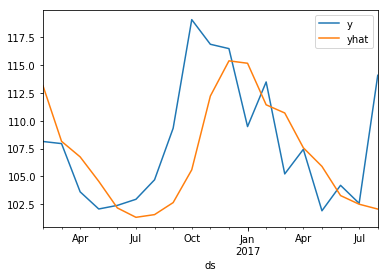

In [12]:
tmp = test.iloc[input_len:,:].copy().set_index('ds')
tmp['yhat'] = prediction
tmp[['y','yhat']].plot()

## 4. Evaluation

In [13]:
error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
print('MAPE:%0.2f%%'%error)

MAPE:5.22%


## 5. Train and evaluate several times

In [14]:
# %%time
# mape_results = []
# for i in range(0,30):
#     K.clear_session()
#     model = Sequential()
#     model.add(SimpleRNN(30, activation='elu', input_shape=(input_len, 1)))
#     model.add(Dense(1))
#     model.compile(optimizer='adadelta', loss='mae')
    
#     earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

#     history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=50, verbose=0, 
#                                callbacks=[earlyStopping], 
#                                validation_data=valid_generator)
    
#     prediction = model.predict_generator(test_generator)
    
#     error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
#     print('MAPE:%0.2f%%'%error)
#     mape_results.append(error)

# print(np.mean(mape_results))

MAPE:10.23%
MAPE:15.73%
MAPE:14.43%
MAPE:5.27%
MAPE:7.80%
MAPE:9.17%
MAPE:10.45%
MAPE:14.09%
MAPE:8.98%
MAPE:11.53%
MAPE:10.22%
MAPE:5.34%
MAPE:9.50%
MAPE:5.31%
MAPE:12.36%
MAPE:9.64%
MAPE:6.96%
MAPE:12.12%
MAPE:8.75%
MAPE:9.08%
MAPE:8.11%
MAPE:12.33%
MAPE:5.38%
MAPE:7.09%
MAPE:19.89%
MAPE:5.56%
MAPE:10.29%
MAPE:11.11%
MAPE:11.70%
MAPE:6.45%
9.82957572232623
CPU times: user 1min 20s, sys: 12 s, total: 1min 32s
Wall time: 2min 27s
